# 1. Xception Net

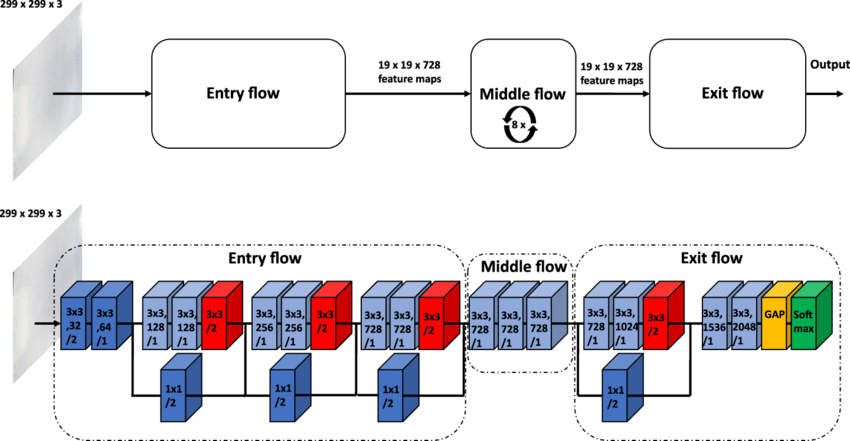

**Điểm đặc biệt của mạng này là sử dụng Depthwise Seperable Convolution**

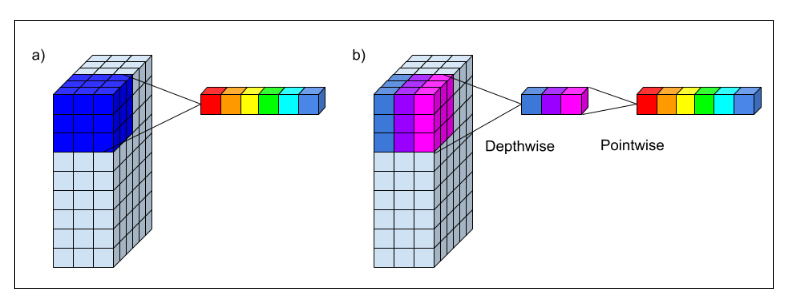

Ảnh đầu vào 12x12x3, kernel 5x5x3, filters 256

Sử dụng phép chập thông thường cần 256x5x5x3x(8x8)=1228800 phép nhân

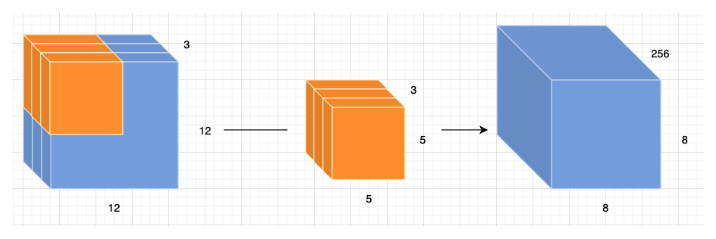

Sử dụng phép chập depthwise separable cần
1. Phần Depthwise phân tách 5x5x3x(8x8) = 4800
2. Phần Pointswise 256x1x1x3x(8x8)= 49152

**Tổng thì ta phải cần 54312 phép nhân ít hơn chập thông thường nên cũng tính toán cũng ít lại.**

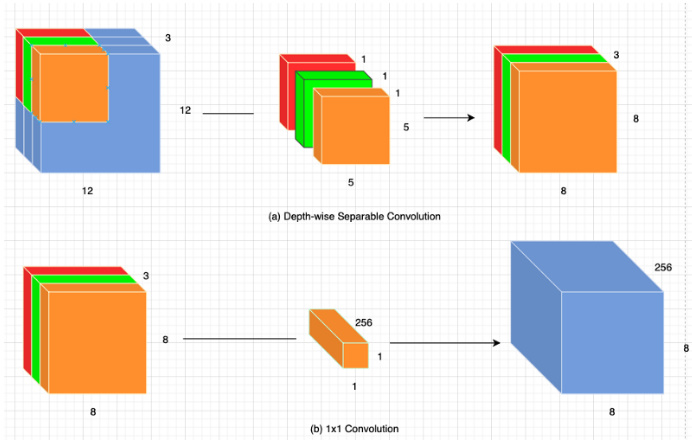

In [1]:
import tensorflow as tf

In [2]:
(X_train,y_train),(X_test,y_test)=tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 13s 0us/step


In [3]:
X_train.shape,X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [4]:
X_train=X_train.astype('float32')/255.0
X_test=X_train.astype('float32')/255.0
y_train=tf.keras.utils.to_categorical(y_train)
y_test=tf.keras.utils.to_categorical(y_test)

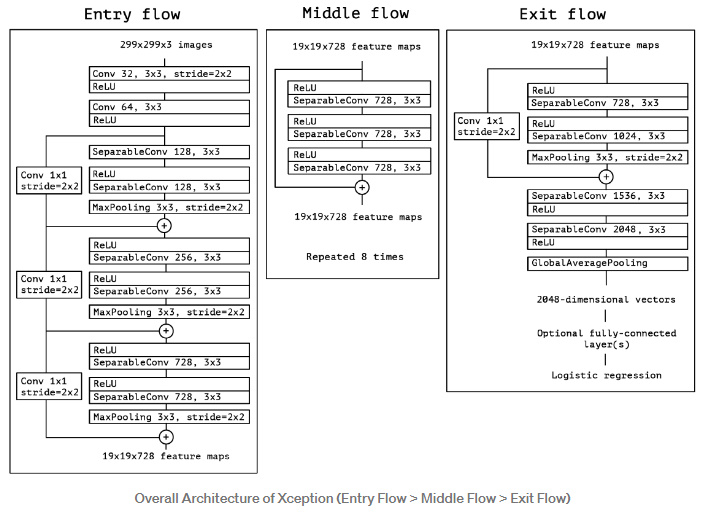

In [5]:
def entry_flow(inputs) :
    x = tf.keras.layers.Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(64,3,padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    previous_block_activation = x

    for filters in [128, 256, 728] :

        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding='same')(previous_block_activation)

        x = tf.keras.layers.Add()([x, residual])
        previous_block_activation = x

    return x

In [6]:
def middle_flow(x, num_blocks=8) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.SeparableConv2D(728, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.SeparableConv2D(728, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.SeparableConv2D(728, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

In [7]:
def exit_flow(x) :

    previous_block_activation = x

    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.SeparableConv2D(728, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.SeparableConv2D(1024, 3, padding='same')(x) 
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = tf.keras.layers.Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = tf.keras.layers.Add()([x, residual])

    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.SeparableConv2D(728, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(10, activation='softmax')(x)

    return x

In [8]:
input_orgin=tf.keras.layers.Input(shape=(32,32,3))
input_resize = tf.keras.layers.experimental.preprocessing.Resizing(224, 224,
interpolation="bilinear",input_shape=(32,32,3))(input_orgin)
outputs = exit_flow(middle_flow(entry_flow(input_resize)))
model = tf.keras.models.Model(inputs=input_orgin, outputs=outputs)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['resizing[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 32  128        ['conv2d[0][0]']             

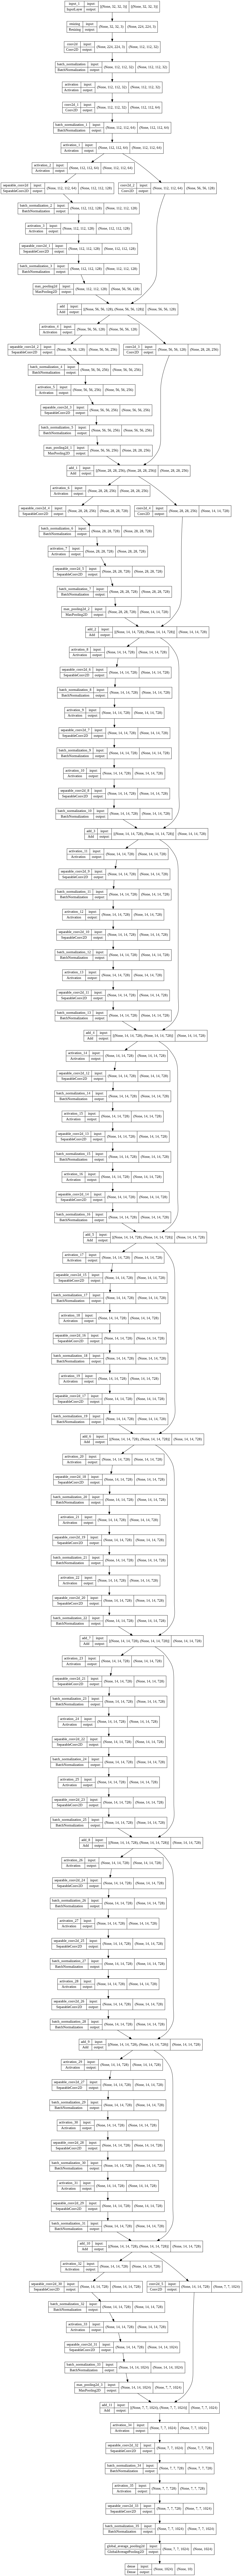

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
X_valid=X_train[40000:]
y_valid=y_train[40000:]

In [12]:
X_train=X_train[:40000]
y_train=y_train[:40000]

In [ ]:
history = model.fit(X_train,y_train, validation_data=(X_valid, y_valid), epochs=2, batch_size=32)

Epoch 1/2
 133/1250 [==>...........................] - ETA: 8:21:32 - loss: 1.8524 - accuracy: 0.3235

In [2]:
import numpy as np
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

In [3]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 0s 0us/step


In [4]:
import matplotlib.pyplot as plt
def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

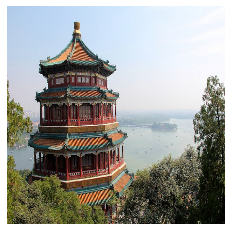

In [5]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


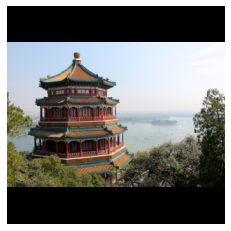

In [6]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

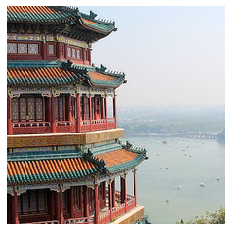

In [7]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

In [8]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])

In [9]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)